In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import scipy as sp
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=2)

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.obabel import load as babel_load
from eden_chem.io.rdkitutils import sdf_to_nx

download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

convert = babel_load
convert = sdf_to_nx
def get_pos_graphs(assay_id): return pipe(assay_id, download_active, convert, list)
def get_neg_graphs(assay_id): return pipe(assay_id, download_inactive, convert, list)

In [3]:
from constrActive.utils import pre_process
from constrActive.utils import _random_sample

def make_data(assay_id, max_size=20):
    # extract pos and neg graphs
    all_pos_graphs, all_neg_graphs = get_pos_graphs(assay_id), get_neg_graphs(assay_id)

    # remove too large and too small graphs and outliers
    args=dict(initial_max_size=2000, fraction_to_remove=.2, n_neighbors_for_outliers=3, remove_similar=False, max_size=max_size)
    logging.info('\nPositive graphs')
    pos_graphs = pre_process(all_pos_graphs, **args)
    logging.info('\nTest positive graphs')
    ts_pos_graphs = _random_sample([g for g in all_pos_graphs if g not in pos_graphs], len(pos_graphs)*2)

    logging.info('\nNegative graphs')
    neg_graphs = pre_process(all_neg_graphs, **args)
    logging.info('\nTest negative graphs')
    ts_neg_graphs = _random_sample([g for g in all_neg_graphs if g not in neg_graphs], len(neg_graphs)*2)
    logger.info('-'*80)
    
    return pos_graphs, neg_graphs, ts_pos_graphs, ts_neg_graphs

In [4]:
from eden.graph import Vectorizer
from sklearn.neighbors import NearestNeighbors
import random

class InstanceMaker(object):
    """InstanceMaker."""

    def __init__(self, n_landmarks=5, n_neighbors=50):
        """init."""
        self.vec = Vectorizer(r=3, d=6,normalization=False, inner_normalization=False)
        self.n_neighbors = n_neighbors
        self.n_landmarks = n_landmarks
        
    def fit(self, graphs):
        self.graphs = graphs
        vecs = self.vec.transform(self.graphs)
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors).fit(vecs)

    def sample(self):
        target_graph = random.sample(self.graphs,1)[0]
        target_vec = self.vec.transform([target_graph])
        distances, neighbors = self.nn.kneighbors(target_vec, return_distance=True)
        distances = distances[0][1:]
        neighbors = neighbors[0][1:]
        ranked_graphs = [self.graphs[i] for i in neighbors]
        landmark_graphs = ranked_graphs[:self.n_landmarks]
        desired_distances = distances[:self.n_landmarks]
        return landmark_graphs, desired_distances, ranked_graphs, target_graph

In [5]:
from eden.graph import Vectorizer

def sort_by_distance_to_target(pareto_set_graphs, target_graph):
    vec = Vectorizer(r=3, d=6,normalization=False, inner_normalization=False)
    pareto_set_vecs = vec.transform(pareto_set_graphs)
    nn = NearestNeighbors(n_neighbors=len(pareto_set_graphs)).fit(pareto_set_vecs) 
    reference_vec = vec.transform([target_graph])
    distances, neighbors = nn.kneighbors(reference_vec,return_distance=True)
    distances = distances[0]
    neighbors = neighbors[0]

    reconstructions = []
    for i,d in zip(neighbors, distances):
        g = pareto_set_graphs[i]
        g.graph['id'] = '%.2f'%(d)
        reconstructions.append(g)
    return reconstructions

In [6]:
def draw_and_annotate_distance(target_graph, reference_graphs, desired_distances, draw_params):
    
    target_graph.graph['id']='%.2f'%0
    
    print('target + nearest neighbors')
    refs = []
    for g,d in zip(reference_graphs, desired_distances):
        g.graph['id']='%.2f'%d
        refs.append(g)
    draw_graph_set([target_graph] + refs, **draw_params)

---

In [7]:
assay_ids=['492992','463230','588350','651610','624466','492952','463213','119','1224857','2326']
args = dict(max_size=20, min_count=2, discretization=50, max_n_neighbors=400)

In [8]:
pos_graphs, neg_graphs, ts_pos_graphs, ts_neg_graphs = make_data(assay_ids[0], max_size=400)

Reading from file: PUBCHEM/AID492992_active.sdf
Reading from file: PUBCHEM/AID492992_inactive.sdf

Positive graphs
original size:2094
random sample:2000
size filter:1800
outlier removal:1146
random sample:400

Test positive graphs
random sample:800

Negative graphs
original size:2820
random sample:2000
size filter:1800
outlier removal:1101
random sample:400

Test negative graphs
random sample:800
--------------------------------------------------------------------------------


In [9]:
# setup colors
from eden.display import map_labels_to_colors
label_colors = map_labels_to_colors(pos_graphs + neg_graphs)
from eden.display import draw_graph_set
draw_params = dict(n_graphs_per_line=5, size=9, colormap='Paired', vertex_color='_labels_', vertex_color_dict=label_colors, vertex_alpha=0.5, edge_alpha=0.2)

target + nearest neighbors


/home/fc334/miniconda2/envs/eden_env/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:511: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/fc334/miniconda2/envs/eden_env/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/fc334/miniconda2/envs/eden_env/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:712: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


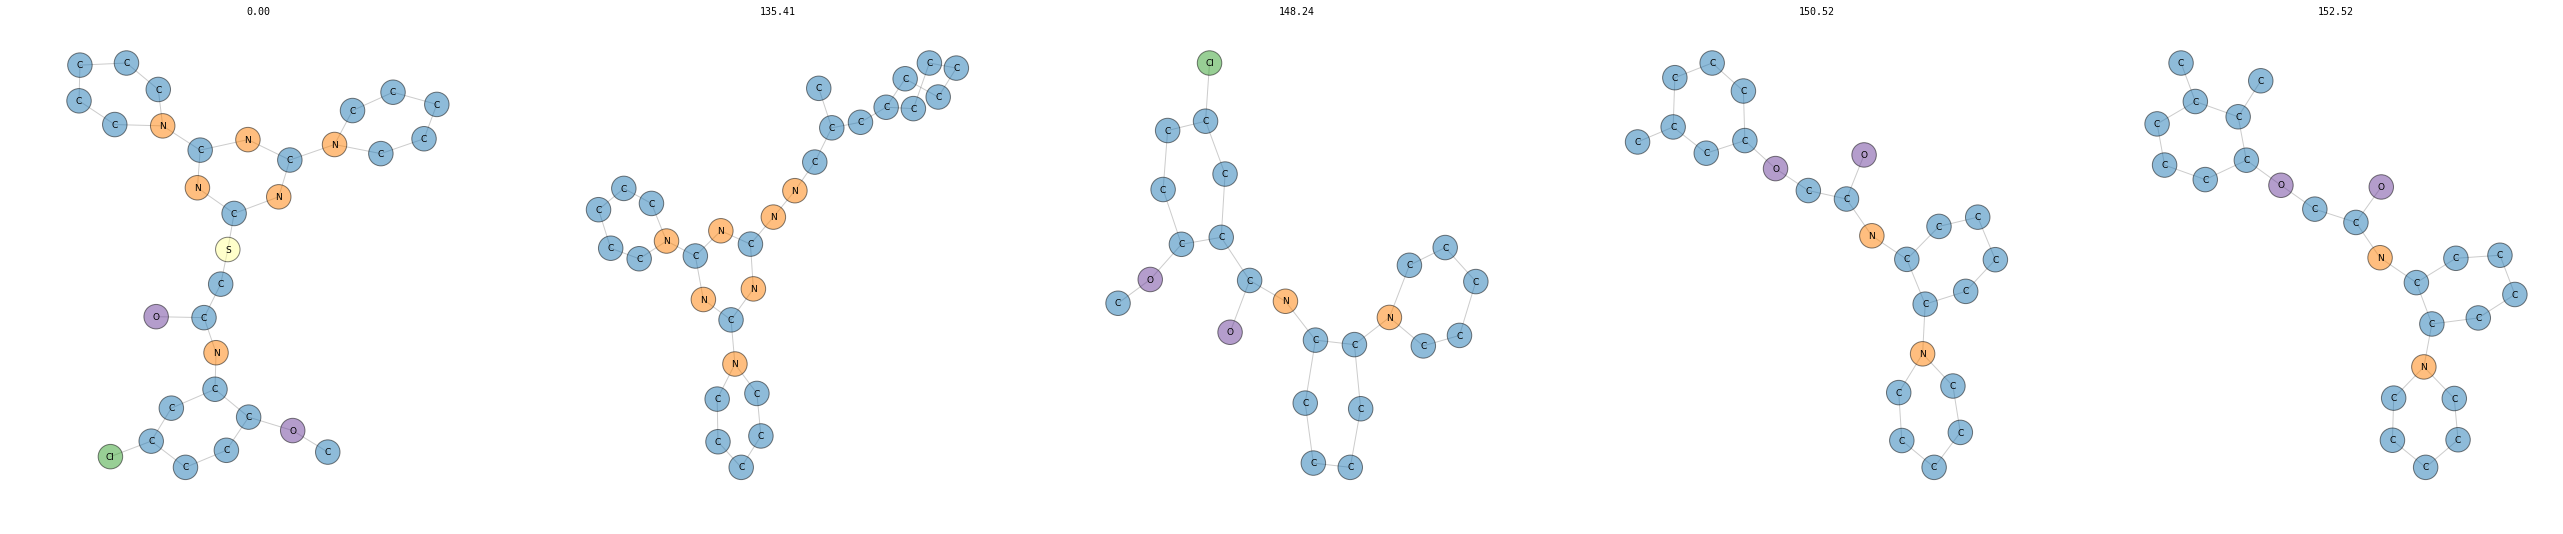

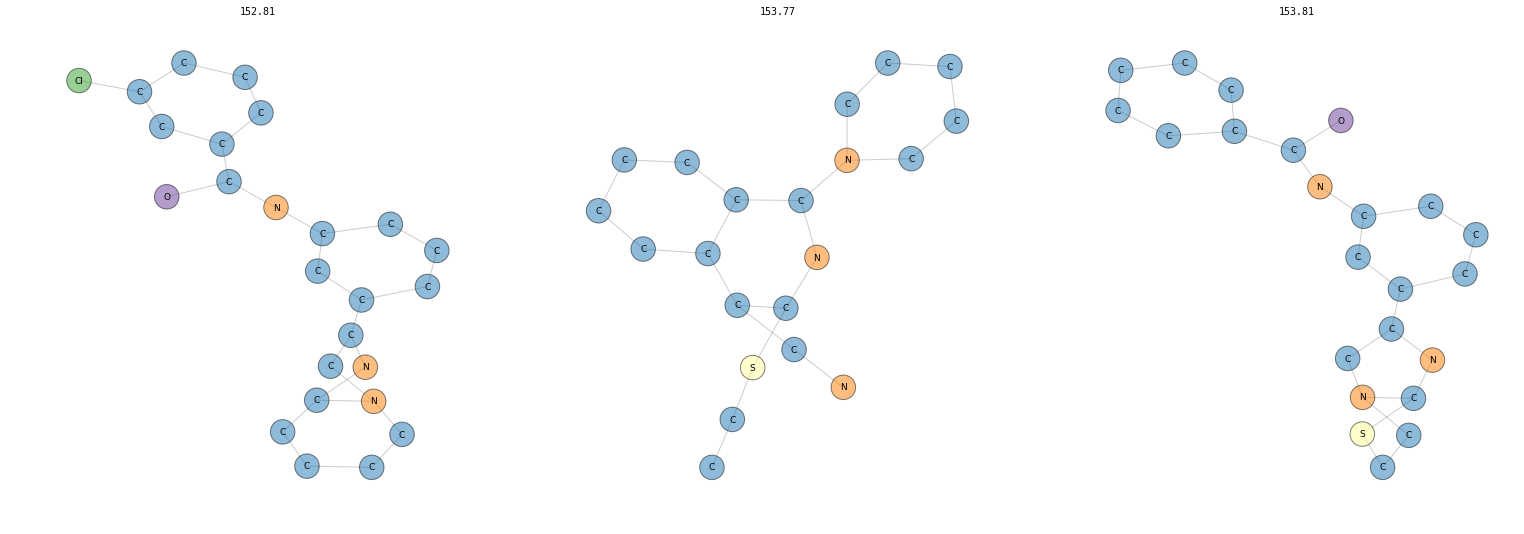

In [10]:
im = InstanceMaker(n_landmarks=7, n_neighbors=50)
im.fit(pos_graphs)
landmark_graphs, desired_distances, ranked_graphs, target_graph = im.sample()
draw_and_annotate_distance(target_graph, landmark_graphs, desired_distances, draw_params)

In [20]:
%%time
from constrActive import construct_from_neighbors
reconstructions = construct_from_neighbors(landmark_graphs=landmark_graphs,
                                  desired_distances=desired_distances,
                                  ranked_graphs=ranked_graphs,
                                  r=3,d=6,min_count=1,context_size=1,
                                  expand_max_n_neighbors=None,
                                  n_iter=2,
                                  expand_max_frontier=1000,
                                  output_k_best=100)   

#interfaces:   331   #cores:  1238   #core-interface-pairs:  1599
fitting: Instances: 2352 ; Features: 65537 with an avg of 1859 per instance
fit  1.18 sec
Init pareto set: starting from:   7 references expanding in: 25892 neighbors for a pareto set of size:  36 
_init_pareto  656.27 sec
iter:   1 current min dist: 0.9115316 median dist: 19.1622172 in pareto set of size: 181 add n neighbors: 191782 
iter:   2 current min dist: 0.5219125 median dist: 29.3302843 in pareto set of size: 482 add n neighbors: 1019216 
optimize  43608.65 sec
CPU times: user 11h 29min 53s, sys: 30min 10s, total: 12h 3s
Wall time: 12h 7min 10s


target vs candidate vs best vs 1-knn


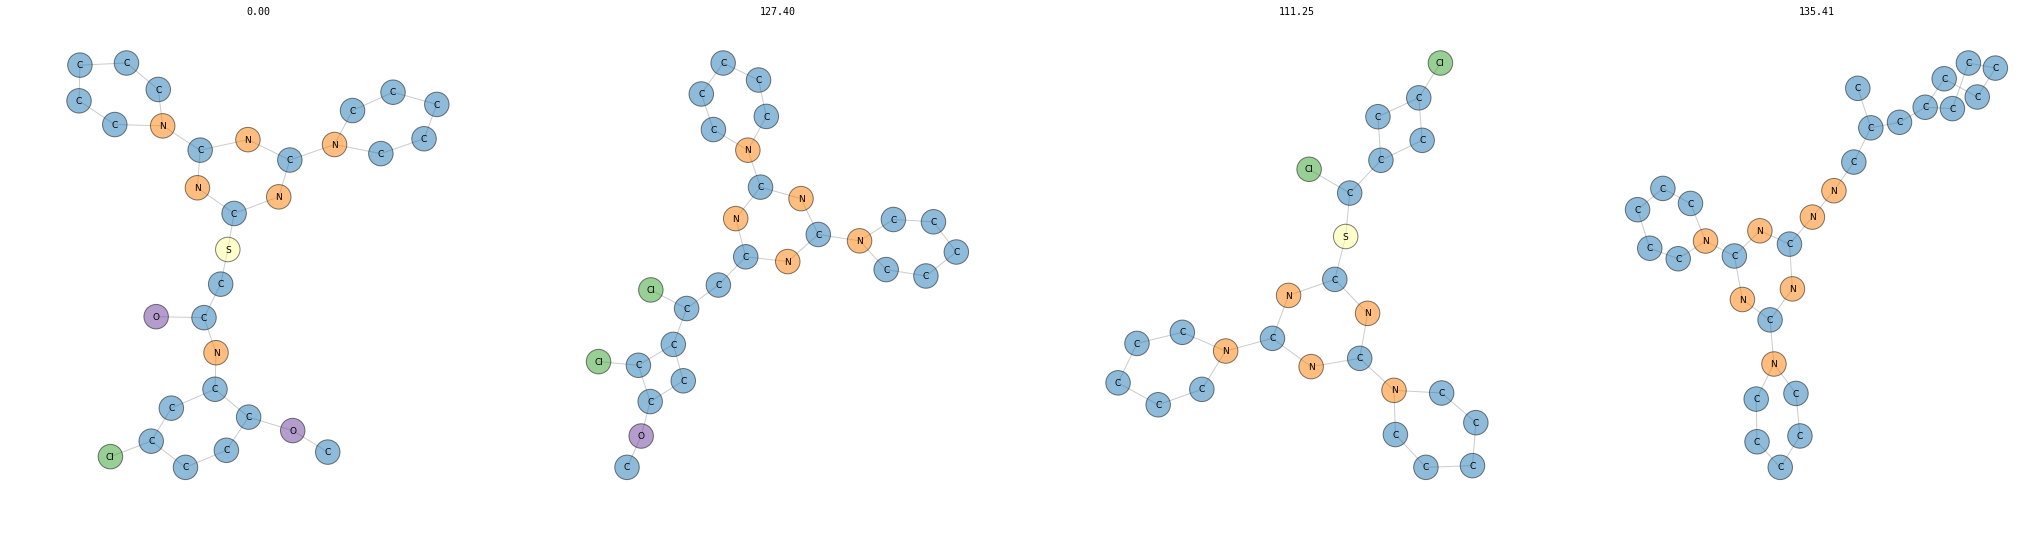

In [21]:
sorted_reconstructions = sort_by_distance_to_target(reconstructions, target_graph)
knn_graphs = sort_by_distance_to_target(ranked_graphs, target_graph)

print('target vs candidate vs best vs 1-knn')
draw_graph_set([target_graph,reconstructions[0],sorted_reconstructions[0],knn_graphs[0]], **draw_params)

target + sorted reconstructions


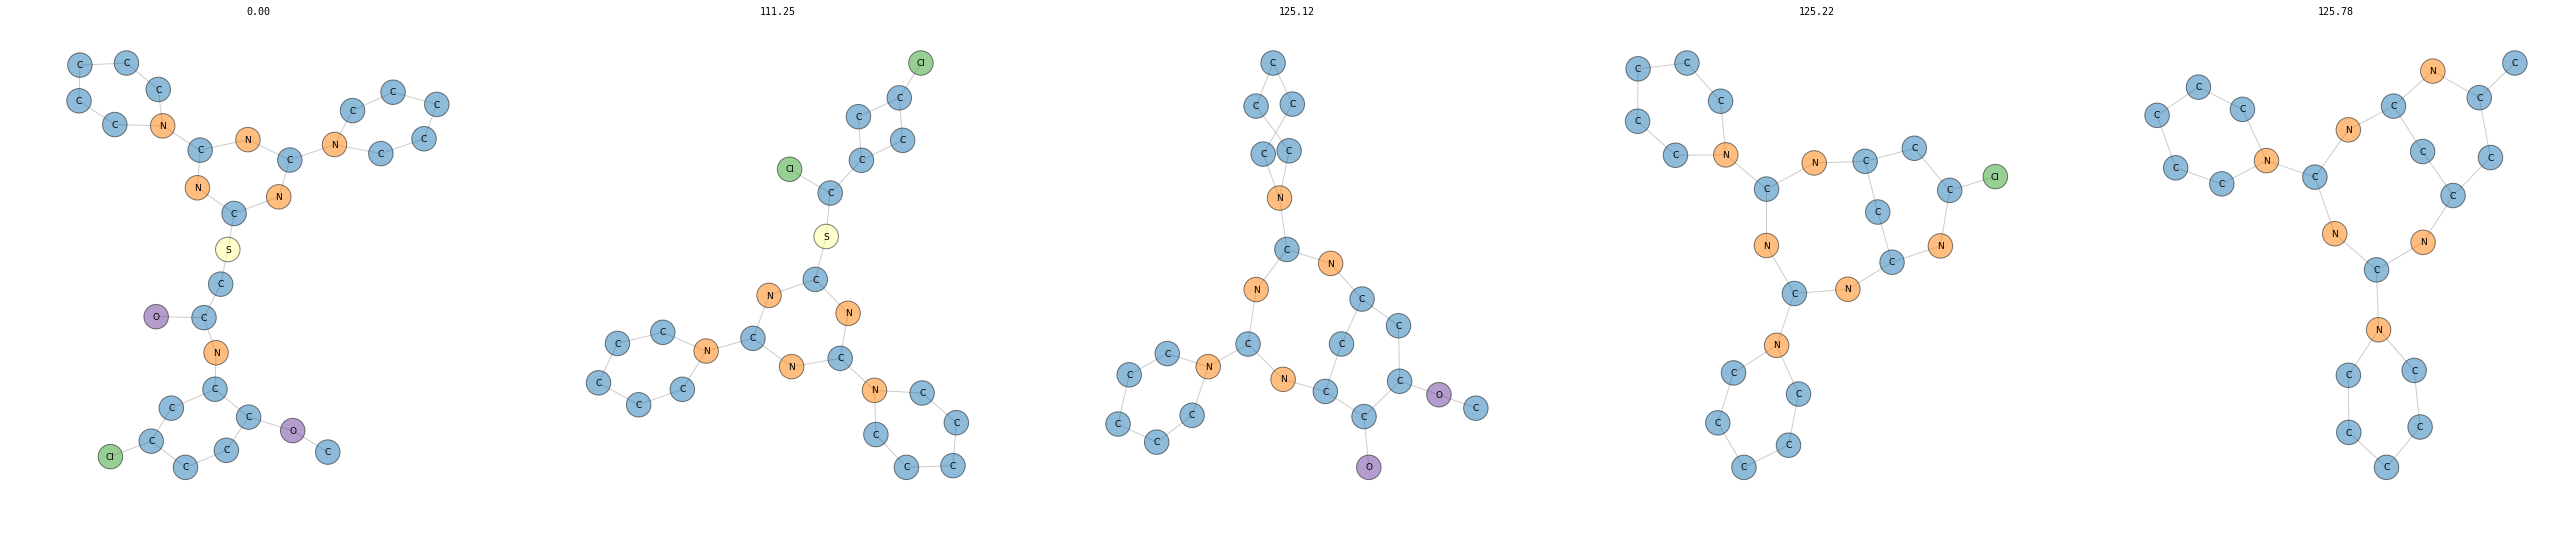

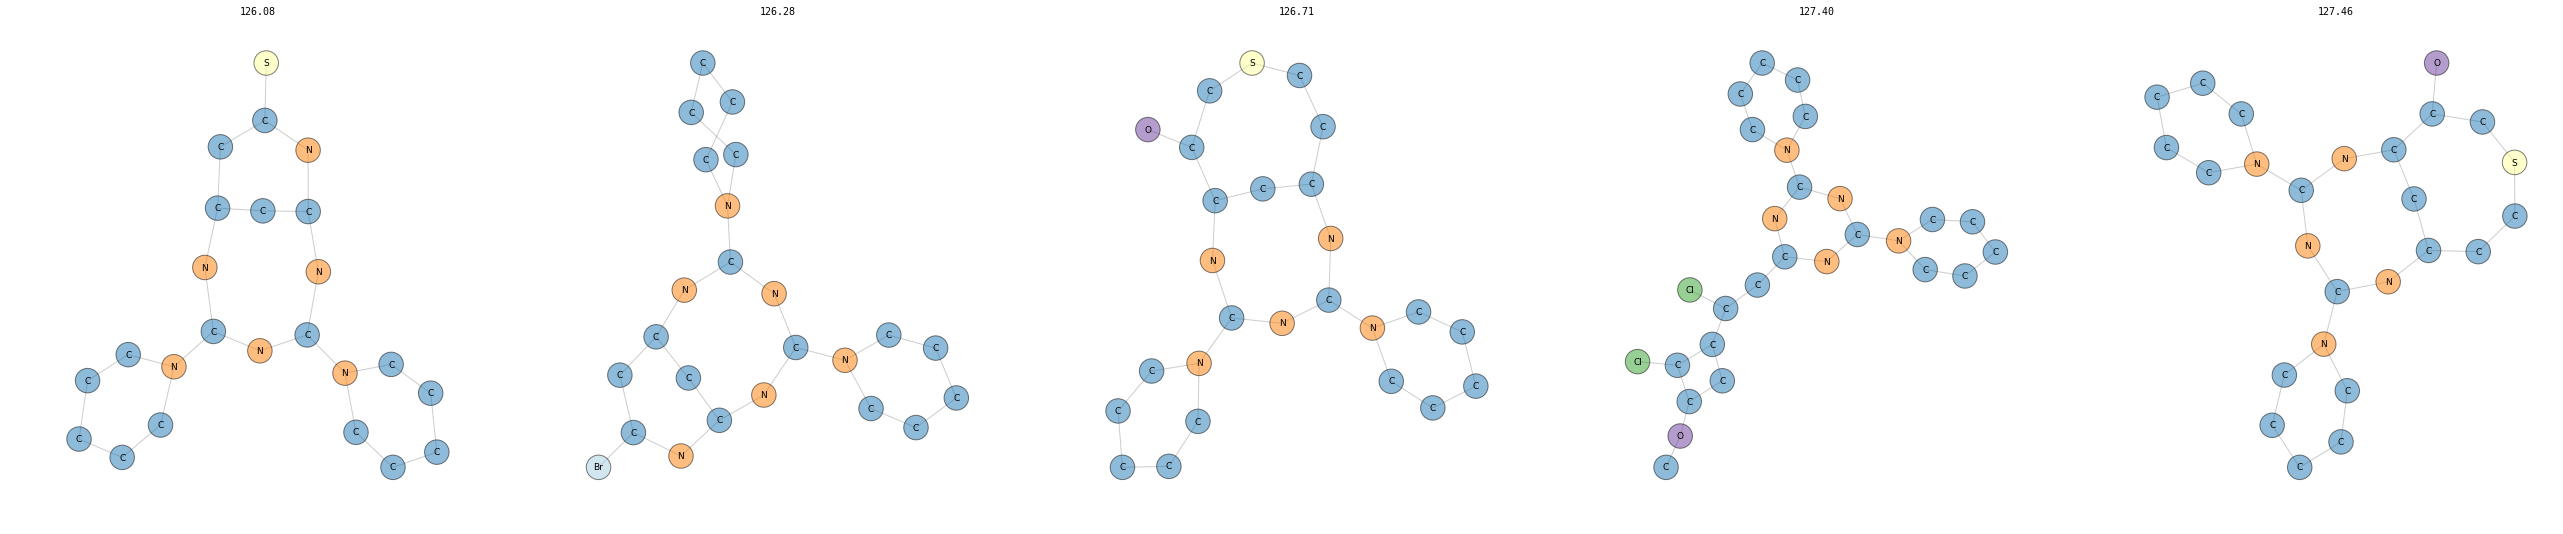

target + knns


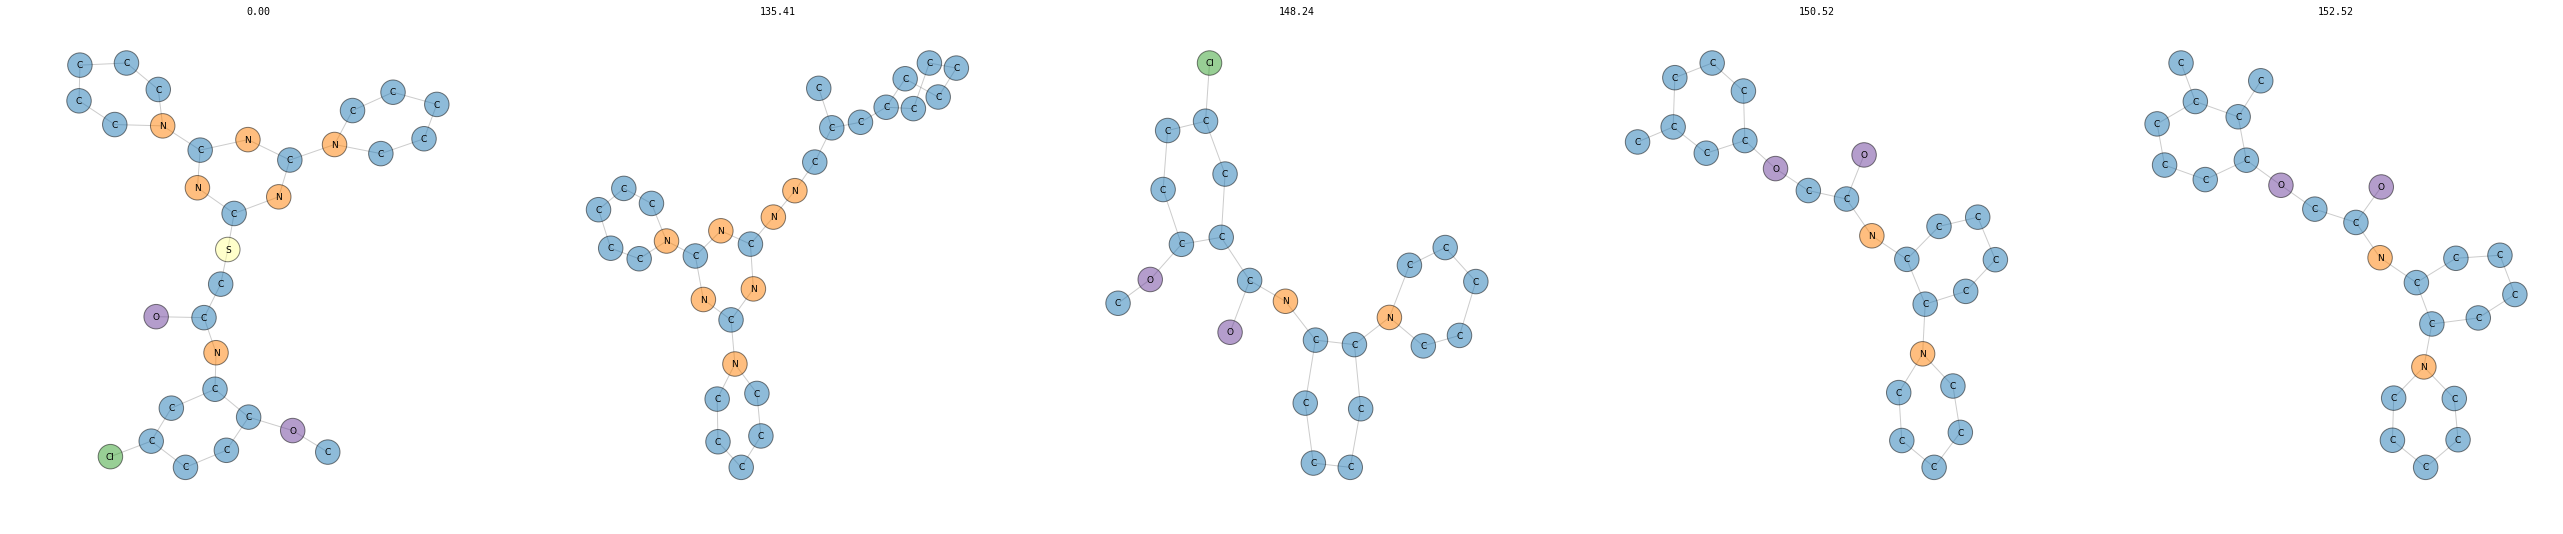

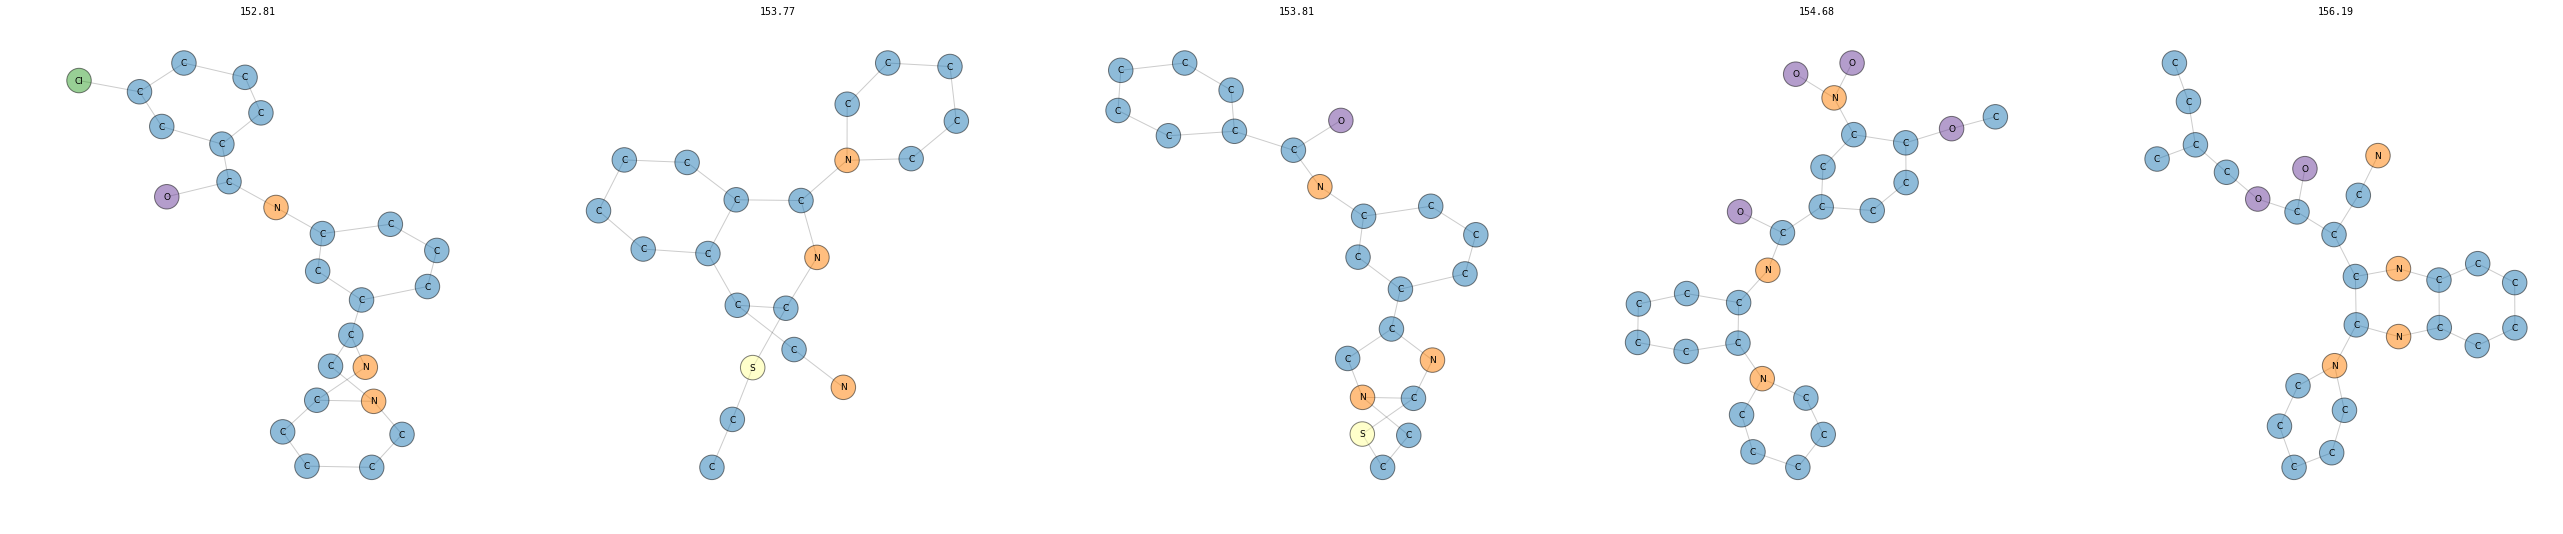

In [22]:
print('target + sorted reconstructions')
draw_graph_set([target_graph] + sorted_reconstructions[:9], **draw_params)
print('target + knns')
draw_graph_set([target_graph] + knn_graphs[:9], **draw_params)

---